# CVAI Project - ZAUBI

In [1]:
import time
import os
import copy
from tqdm import tqdm

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.io import read_image

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage import io, color
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from zaubi import CustomImageDataset

#from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
DATA_DIR = 'data/mtg-image-data'

BATCH_SIZE = 32
NUM_WORKERS = 4

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## Data Preprocessing

### Data Collection

In [3]:
#load the dataset from disk
from datasets import load_from_disk
dataset = load_from_disk("data/mtg-image-data")
dataset

labels = ['colorless', 'blue', 'black', 'white', 'green', 'red']

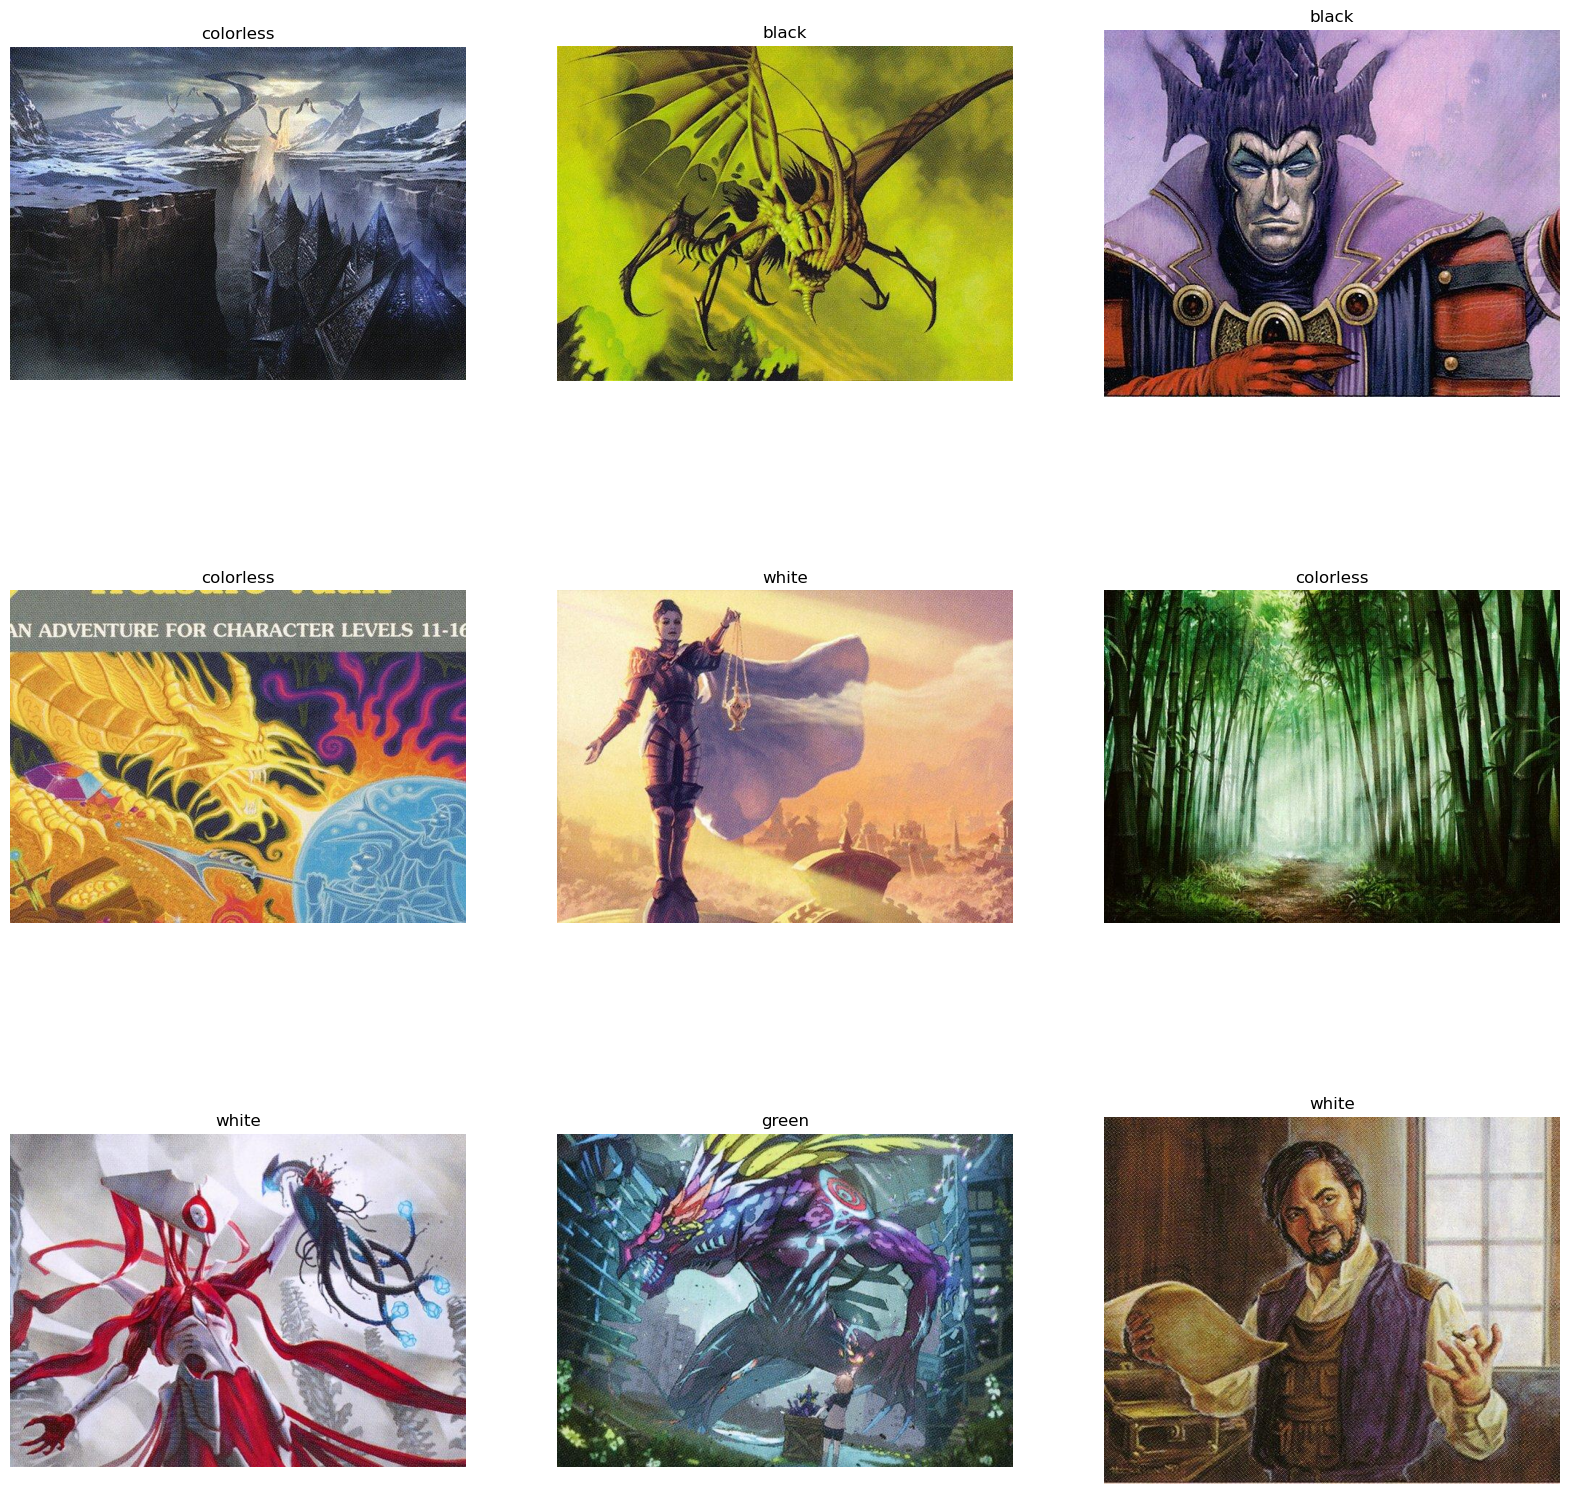

In [4]:
# Define a function to visualize n random images with mana color labels, 3 per row
def visualize_images(dataset, n=9):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        plt.subplot(n // 3, 3, i + 1)
        random_index = random.randint(0, len(dataset))
        image = dataset[random_index]['image']
        label = dataset[random_index]['mana_color']
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Visualize some random images
visualize_images(dataset)



In [5]:
len(dataset)

23848

In [6]:
# Compute the labels distribution

#label_counts = {label: 0 for label in labels}
#for example in dataset:
#    label = example['mana_color']
#    label_counts[label] += 1
#label_counts

In [7]:
# plot the distribution of labels
# Define the color map
color_discrete_map = {'colorless': 'gray', 'blue': 'deepskyblue', 'black': 'black', 'white': 'cornsilk', 'green': 'darkgreen', 'red': 'firebrick'}

#fig = px.bar(x=labels, y=[label_counts[label] for label in labels], title='Mana Color Distribution', color = labels, color_discrete_map = color_discrete_map)
#fig.update_layout(xaxis_title='Mana Color', yaxis_title='Count', showlegend=False)
#fig.show()

## Model Building

### Load the pre-trained model

In [17]:
import ssl
from torchvision.models import resnet50, ResNet50_Weights

ssl._create_default_https_context = ssl._create_unverified_context

# Initialize the Weight Transform
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [18]:
# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

In [19]:
# Modify the last layer of the model
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(labels))
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def calculate_mean_std(dataset):
    mean = []
    std = []
    for example in tqdm(dataset):
        image = example['image']
        image = np.array(image) / 255.0
        mean.append(image.mean(axis=(0, 1)))
        std.append(image.std(axis=(0, 1)))
    mean = np.array(mean).mean(axis=0)
    std = np.array(std).mean(axis=0)
    return mean, std

In [21]:
# Split the dataset into train, val, and test sets (e.g., 80% train, 10% val, 10% test)
train_size = int(0.95 * len(dataset))
#val_size = int(0.1 * len(dataset))
#test_size = len(dataset) - train_size - val_size
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f'Train dataset: {len(train_dataset)}', f'Test dataset: {len(test_dataset)}')

# Calculate mean and std
# mean, std = calculate_mean_std(train_dataset)

# Replace these with the calculated values
# MEAN = mean.tolist()
# STD = std.tolist()

MEAN = [0.42134006, 0.3821774,  0.35155704]
STD = [0.2148991,  0.20553289, 0.19561084]

print(f'Mean: {MEAN}')
print(f'Std: {STD}')

# Define the custom transform without data augmentation
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Define transformations including data augmentation for the training set
custom_transform_DA = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Define transformations for the validation and test sets
custom_val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])


# Define transformations including data augmentation for the training set
train_transform_DA = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the validation and test sets
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Train dataset: 22655 Test dataset: 1193
Mean: [0.42134006, 0.3821774, 0.35155704]
Std: [0.2148991, 0.20553289, 0.19561084]


In [22]:
# Apply transformations to each split
train_trans = CustomImageDataset(train_dataset, labels, transform=custom_transform)
#val_trans = CustomImageDataset(val_dataset, labels,  transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_trans, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#val_loader = DataLoader(val_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [23]:
# Define the training function with learning rate scheduler and early stopping
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):

    # Initialize early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Define a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                # Move the inputs and labels to the device
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print the epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

        # Learning rate scheduler step
        scheduler.step()

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break


In [34]:
# Define a similar training function that implements stratified k-fold CV and data augmentation
def train_k_fold(model, dataset, labels, criterion, optimizer, num_epochs, k=5, patience=3):
    # Initialize the StratifiedKFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize the running loss and accuracy
    running_loss = 0.0
    running_corrects = 0

    for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1}/{k}")

        # Split the dataset into train and validation sets
        train_dataset = Subset(dataset, train_index.tolist())
        val_dataset = Subset(dataset, val_index.tolist())
        
        # Apply transformations to each split
        train_trans = CustomImageDataset(train_dataset, labels, transform=custom_transform_DA)
        val_trans = CustomImageDataset(val_dataset, labels, transform=custom_val_test_transform)
        
        # Create DataLoaders
        train_loader = DataLoader(train_trans, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        
        # Train the model
        train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience)


In [ ]:
# Set the device
model.to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Fine-tune the last layer for a few epochs
#train(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, patience = 4)
#train_k_fold(model, train_dataset, labels, criterion, optimizer, num_epochs=NUM_EPOCHS, k=5, patience=4)

 # Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
#train(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, patience = 4)
train_k_fold(model, train_dataset, labels, criterion, optimizer, num_epochs=10, k=4, patience=4)

Fold 1/4


Training Epoch 1/10:  49%|████▉     | 262/531 [01:32<01:34,  2.84it/s]

In [30]:
# save the model to disk
torch.save(model.state_dict(), "mtg_image_classifier_CustomTransform_noDA_5kfCV_SGD_0.001.bs32.pth")

In [17]:
# load the model from disk
model = resnet50(weights=ResNet50_Weights.DEFAULT)
# Modify the last layer of the model
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(labels))
)
model.load_state_dict(torch.load("mtg_image_classifier_CustomTransform_noDA_5kfCV_SGD_0.001.bs32.pth"))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

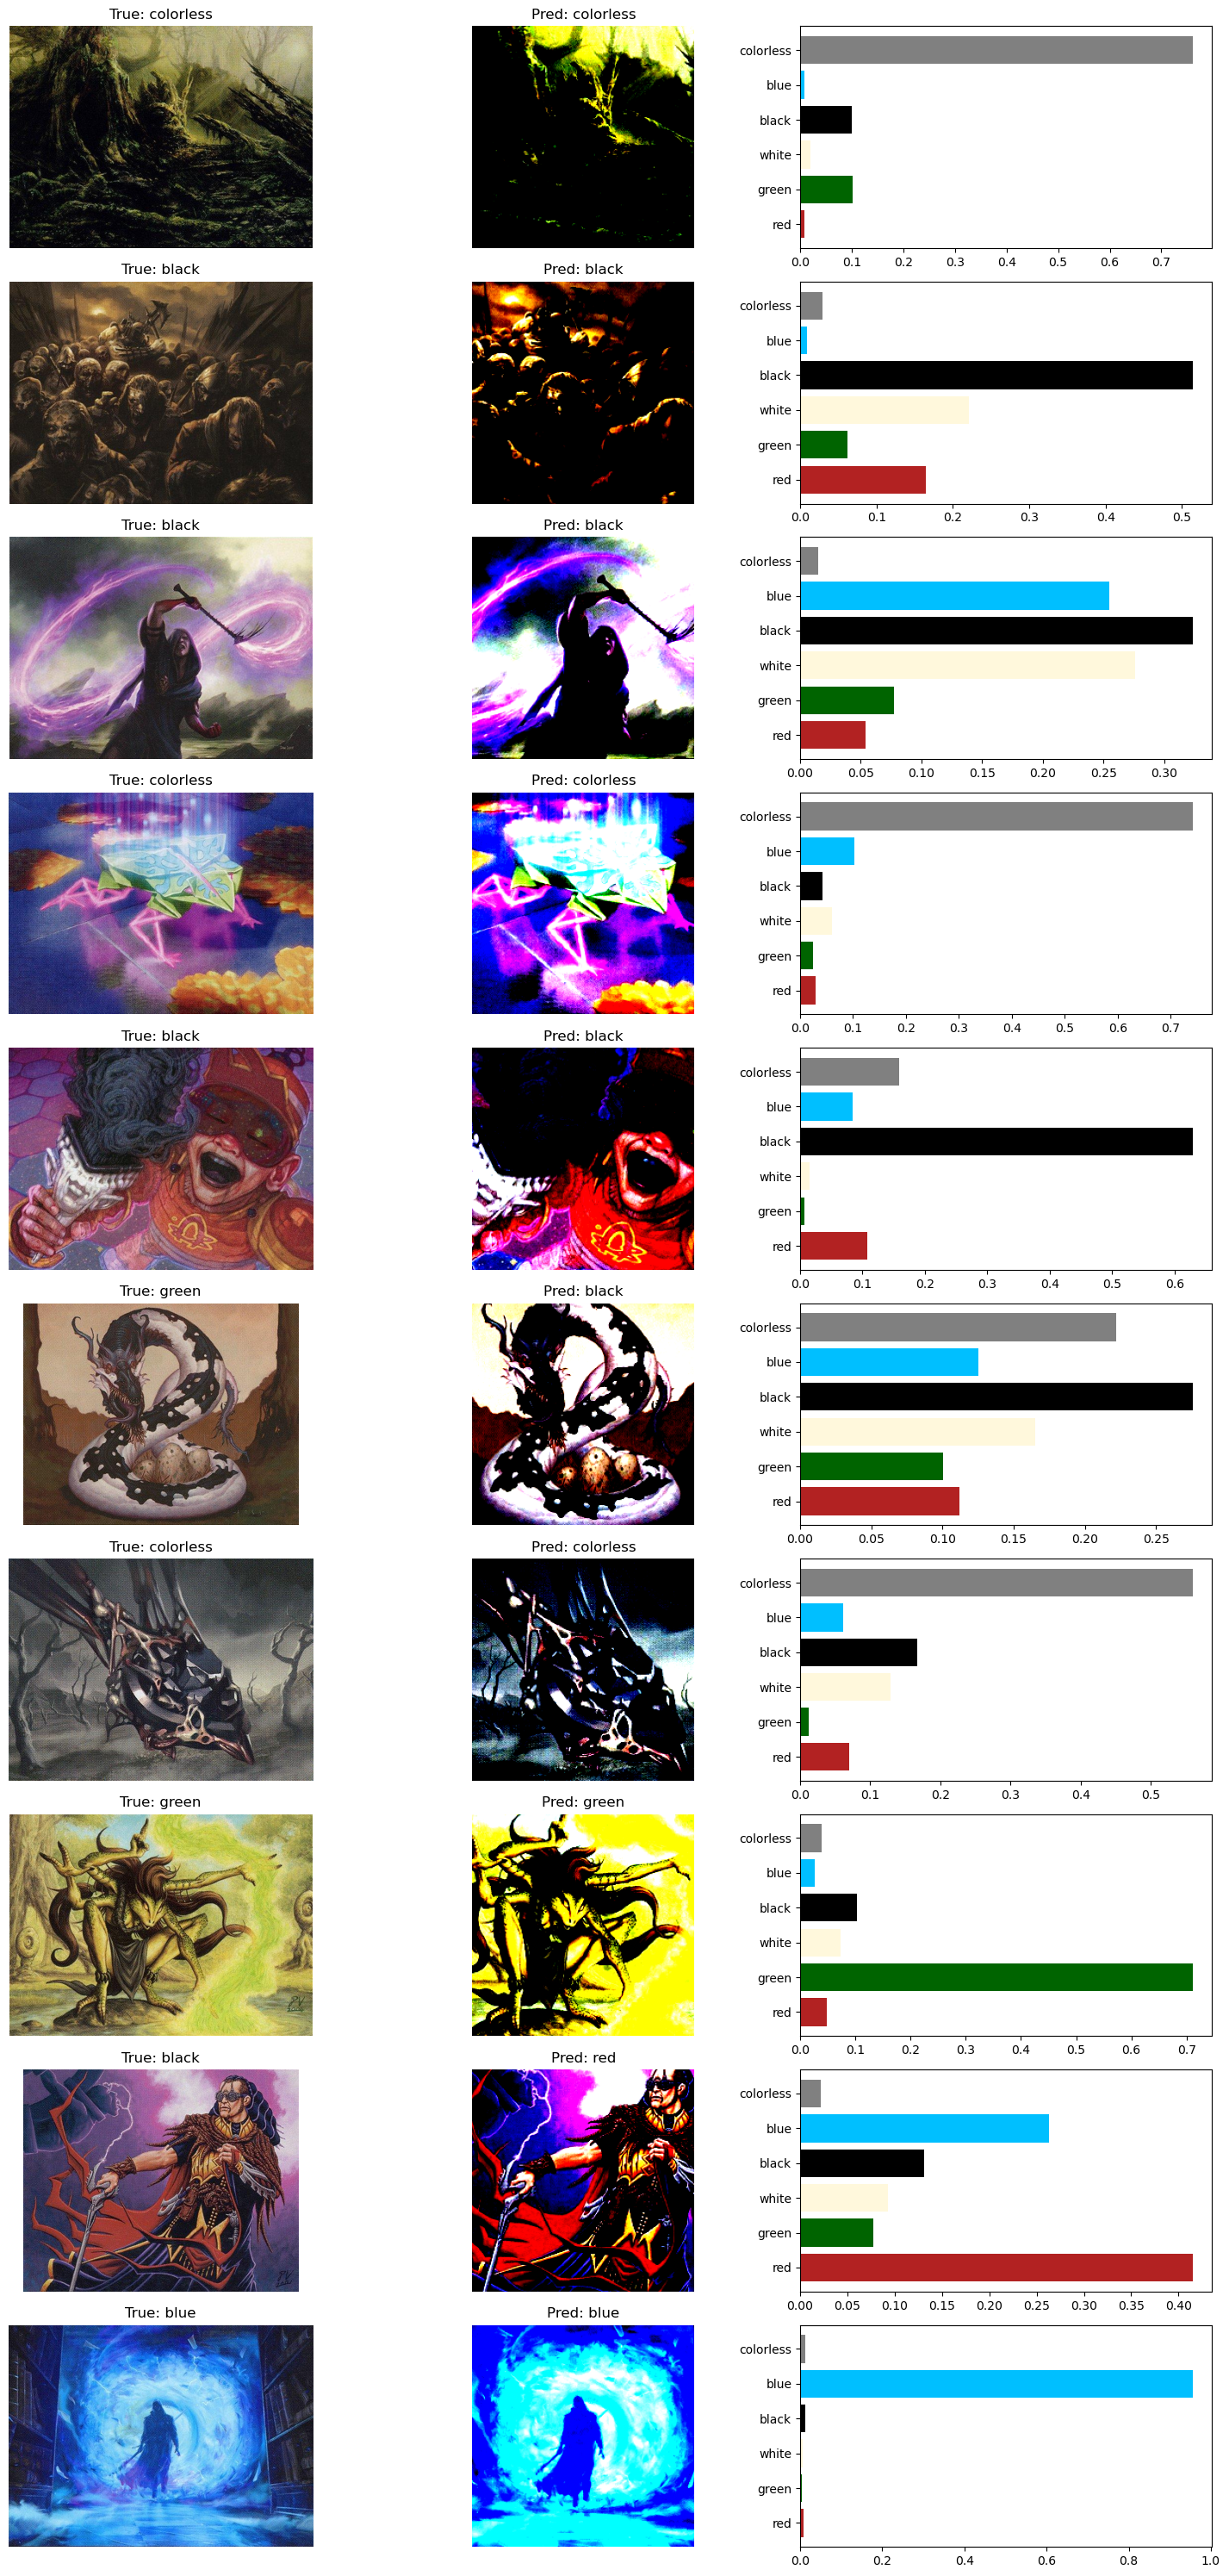

In [33]:
# Make n predictions and the plot the original image, the transformed image, and the probabilities as a bar chart. 
# Put the true label as the title of the original image and the predicted label as the title of the transformed image. 

def visualize_predictions(model, test_dataset, transform, labels_names, n_images=10):
    model.eval()
    model.to(DEVICE)
    
    # Sample n random images
    samples, _ = torch.utils.data.random_split(test_dataset, [n_images, len(test_dataset) - n_images])
    
    # Store original images
    original_images = [sample['image'] for sample in samples]
    
    # Apply transformations
    samples = CustomImageDataset(samples, labels_names, transform=transform)
    
    # Create DataLoader
    test_loader = DataLoader(samples, batch_size=n_images, shuffle=False)
    
    # Prepare the figure
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 3 * n_images))
    
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        
        for j in range(n_images):
            # Original image
            ax = axes[j, 0]
            ax.imshow(original_images[j])
            ax.axis('off')
            ax.set_title(f"True: {labels_names[labels[j].item()]}")
            
            # Transformed image
            ax = axes[j, 1]
            ax.imshow(inputs[j].permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
            ax.set_title(f"Pred: {labels_names[preds[j].item()]}")
            
            # Probabilities
            ax = axes[j, 2]
            y_pos = np.arange(len(labels_names))
            probabilities = probs[j].cpu().detach().numpy()
            colors = [color_discrete_map[labels_names[i]] for i in range(len(labels_names))]
            
            ax.barh(y_pos, probabilities, color=colors)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels_names)
            ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, custom_transform, labels, 10)

In [32]:
# Evaluate the model on the test set

# Apply transformations to the test set
test_trans = CustomImageDataset(test_dataset, labels, transform=custom_transform)

# Create DataLoader
test_loader = DataLoader(test_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

def evaluate(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    model.to(DEVICE)

    # Initialize the running loss and corrects
    running_loss = 0.0
    running_corrects = 0

    # Initialize the predictions and labels list
    all_preds = []
    all_labels = []

    # Iterate over the batches of the test loader
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Update the running loss and corrects
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Append the predictions and labels to the lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate the test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate the model
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
    

Testing: 100%|██████████| 38/38 [00:05<00:00,  7.17it/s]

Test loss: 1.2608, Test accuracy: 0.5457
